# Pipeline for High-z Radio Galaxies 06: Application of full pipeline for prediction with optimised thresholds

## Introduction

In this file, three models will be applied consecutively in order to predict  
the detection of Radio Galaxies (radio AGN) and their redshift.  

In principle, this pipeline should be applied to data in Stripe 82. But  
it can be used with any other suitable dataset.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn.pipeline
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import mpl_scatter_density
from joblib import dump, load
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Functions to predict values

In [3]:
def predict_star(catalog_df, star_model, cal_str_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(star_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_1'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    catalog_df.loc[:, 'Score_no_star'] = np.around(catalog_df.loc[:, 'Score_no_star'], decimals=7)
    pred_probs = cal_str_model.predict(catalog_df.loc[:, 'Score_0'])
    cal_class  = np.array(pred_probs < (1 - cal_threshold)).astype(int)
    catalog_df['Prob_no_star']  = pred_probs
    catalog_df['pred_star_cal'] = cal_class
    return catalog_df

In [4]:
def predict_AGN_gal(catalog_df, AGN_gal_model, cal_AGN_gal_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(AGN_gal_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
    catalog_df.loc[:, 'Score_AGN'] = np.around(catalog_df.loc[:, 'Score_AGN'], decimals=7)
    pred_probs = cal_AGN_gal_model.predict(catalog_df.loc[:, 'Score_AGN'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_AGN']       = pred_probs
    catalog_df['pred_class_cal'] = cal_class
    return catalog_df

In [5]:
def predict_radio_det(catalog_df, radio_model, cal_radio_model, threshold, cal_threshold, raw_score=True):
    catalog_df = pyc.predict_model(radio_model, data=catalog_df, probability_threshold=threshold, raw_score=raw_score, round=10)
    catalog_df = catalog_df.drop(columns=['Score_0'])
    catalog_df = catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
    catalog_df.loc[:, 'Score_radio'] = np.around(catalog_df.loc[:, 'Score_radio'], decimals=7)
    pred_probs = cal_radio_model.predict(catalog_df.loc[:, 'Score_radio'])
    cal_class  = np.array(pred_probs >= cal_threshold).astype(int)
    catalog_df['Prob_radio']     = pred_probs
    catalog_df['pred_radio_cal'] = cal_class
    return catalog_df

In [6]:
def predict_z_full(catalog_df, redshift_model):
    catalog_df = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    catalog_df = catalog_df.rename(columns={'Label': 'pred_Z'})
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [7]:
def predict_z_high(catalog_df, redshift_model, z_lim, z_tol):
    catalog_df    = pyr.predict_model(redshift_model, data=catalog_df, round=10)
    filter_pred_z = catalog_df.loc[:, 'pred_Z'] >= (z_lim + z_tol)
    catalog_df.loc[:, 'pred_Z'] = catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, catalog_df.loc[filter_pred_z, 'Label'])
    catalog_df    = catalog_df.drop(columns=['Label'])
    catalog_df.loc[:, 'pred_Z'] = np.around(catalog_df.loc[:, 'pred_Z'], decimals=4)
    return catalog_df

In [8]:
def M12_AGN_criterion(catalog_df):
    M12_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 <
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 0.791) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           0.315 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 0.222) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           -3.172 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) + 7.624)).astype(int)
    return M12_column

In [9]:
def S12_AGN_criterion(catalog_df):
    S12_column = np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >= 0.8).astype(int)
    return S12_column

In [10]:
def M16_AGN_criterion(catalog_df):
    M16_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 < 4.4)).astype(int)
    return M16_column

In [11]:
def B18_AGN_criterion(catalog_df):
    B18_column = (np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 > 0.5) &
                  np.array(catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174 > 2.2) &
                  np.array(catalog_df.loc[:, 'W1mproPM'] - catalog_df.loc[:, 'W2mproPM'] - 2.699 + 3.339 >
                           2 * (catalog_df.loc[:, 'W2mproPM'] - catalog_df.loc[:, 'W3mag'] - 3.339 + 5.174) - 8.9)).astype(int)
    return B18_column

In [12]:
def add_AGN_criteria(catalog_df):
    catalog_df['M12_AGN'] = M12_AGN_criterion(catalog_df)
    catalog_df['S12_AGN'] = S12_AGN_criterion(catalog_df)
    catalog_df['M16_AGN'] = M16_AGN_criterion(catalog_df)
    catalog_df['B18_AGN'] = B18_AGN_criterion(catalog_df)
    return catalog_df

---

## Reading data

Flags.

In [13]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = False  # z >= 3.7 (with SMOGN), or, if needed, z >= 4.0 ***
use_calibration     = True
compare_A17_flag    = True  # Compare with the results from Ananna et al., 2017

In [14]:
used_area           = 'HETDEX'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Validation, Training, Test, Test+Train, 'Calibration'
if used_area != 'HETDEX':
    HETDEX_subset   = ''

In [15]:
if used_area != 'S82':
    compare_A17_flag = False

In [16]:
file_name_dict      = {'S82': gv.file_S82, 'HETDEX': gv.file_HETDEX, 'COSMOS': gv.file_COSMOS}
file_name           = file_name_dict[used_area]

In [17]:
feats_2_disc_S82    = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']
feats_2_disc_HETDEX = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect', 'LoLSS_detect']
feats_2_disc_COSMOS = ['RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag',\
                       'num_imputed', 'radio_detect', 'TGSS_detect', 'VLASS_detect']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [18]:
full_catalog_df     = pd.read_hdf(gv.cat_path + file_name, key='df').drop(columns=features_2_discard)

In [19]:
if used_area == 'S82':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'VLAS82_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['VLAS82_detect'])
if used_area == 'COSMOS':
    full_catalog_df.loc[:, 'LOFAR_detect'] = full_catalog_df.loc[:, 'COSMOSVLA3_detect'].copy()
    full_catalog_df = full_catalog_df.drop(columns=['COSMOSVLA3_detect'])

Create features with class and combined redshift.

In [20]:
if use_zeroth_model:
    full_catalog_df['is_str'] = np.array(full_catalog_df.loc[:, 'spCl'] == 'STAR  ').astype(int)
elif not use_zeroth_model:
    full_catalog_df['is_str'] = np.zeros_like(full_catalog_df.loc[:, 'spCl'])

In [21]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

Create column for detection as Radio AGN

In [22]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

Show early statistics of confirmed sources

In [23]:
print(f'In the {used_area} field, there are {np.sum(full_catalog_df.loc[:, "class"] != 0.5):,} confirmed sources.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 0):,} of them are galaxies.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 1):,} of them are AGN.')
print(f'{np.sum(full_catalog_df.loc[:, "class"] == 2):,} of them are stars.')

In the HETDEX field, there are 83,409 confirmed sources.
55,158 of them are galaxies.
28,251 of them are AGN.
0 of them are stars.


---

Split dataset if from HETDEX

In [24]:
if used_area == 'HETDEX':
    if use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
            (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
    elif not use_zeroth_model:
        filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
    unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
    full_catalog_df   = full_catalog_df.loc[filter_known_spec]
    train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
    print('Shape of used data in HETDEX')
    print('-' * 65)
    print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
    print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
    print(f'Training data:                                    {train_df.shape}')
    print(f'Testing data:                                     {test_df.shape}')
    if use_calibration:
        print(f'Calibration data:                                 {calibration_df.shape}')
    print(f'Validation data:                                  {validation_df.shape}')
    print('-' * 65)
    print()
    print(f'Using {HETDEX_subset} data from HETDEX')
    selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                        'Validation': validation_df, 'Calibration': calibration_df}
    full_catalog_df = selected_dataset[HETDEX_subset]

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (83409, 100)
Data for Modeling (Train, Test, and Calibration): (66727, 100)
Training data:                                    (53381, 100)
Testing data:                                     (6673, 100)
Calibration data:                                 (6673, 100)
Validation data:                                  (16682, 100)
-----------------------------------------------------------------

Using Validation data from HETDEX


Split data if not from HETDEX

In [25]:
if used_area != 'HETDEX':
    filter_confirmed = (full_catalog_df.loc[:, 'class'] == 0) |\
                       (full_catalog_df.loc[:, 'class'] == 1) |\
                       (full_catalog_df.loc[:, 'class'] == 2)  # Galaxy, AGN, star
    unknown_cat_df   = full_catalog_df.loc[~filter_confirmed]
    full_catalog_df  = full_catalog_df.loc[filter_confirmed]

In [26]:
print(f'Full used dataset size:              {full_catalog_df.shape}')
print('-' * 50)
print(f'Thus, it has {full_catalog_df.shape[0]:,} sources and {full_catalog_df.shape[1]:,} features.')

Full used dataset size:              (16682, 100)
--------------------------------------------------
Thus, it has 16,682 sources and 100 features.


Discard minor features.

In [27]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'zsp', 'spCl'])

---

### Load models

In [28]:
if load_models_flag:
    if use_zeroth_model:
        star_clf        = pyc.load_model(gv.models_path + gv.star_model)  # star/no-star model
        cal_star_clf    = load(gv.models_path + gv.cal_str_model)  # calibrated model
    AGN_gal_clf         = pyc.load_model(gv.models_path + gv.AGN_gal_model)  # 
    cal_AGN_gal_clf     = load(gv.models_path + gv.cal_AGN_gal_model)  # calibrated model
    radio_det_clf       = pyc.load_model(gv.models_path + gv.radio_model)  # without predicted AGN
    cal_radio_det_clf   = load(gv.models_path + gv.cal_radio_model)  # calibrated model
    redshift_reg        = pyr.load_model(gv.models_path + gv.full_z_model)  # to use on full sample
    if use_second_z_model:
        redshift_reg_2  = pyr.load_model(gv.models_path + gv.high_z_model)  # to use on sources with predicted z >= 3.6 used with SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Predictions with optimised thresholds.

In [29]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = predict_star(full_catalog_df, star_clf, cal_star_clf, gv.star_thresh, gv.cal_str_thresh)
    unknown_cat_df  = predict_star(unknown_cat_df,  star_clf, cal_star_clf, gv.star_thresh, gv.cal_str_thresh)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1
    full_catalog_df['Prob_no_star']  = 1
    full_catalog_df['pred_star_cal'] = 0
    unknown_cat_df['pred_star']      = 0
    unknown_cat_df['pred_star_cal']  = 0
    unknown_cat_df['Score_no_star']  = 1
    unknown_cat_df['Prob_no_star']   = 1

In [30]:
full_catalog_df = predict_AGN_gal(full_catalog_df, AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)
unknown_cat_df  = predict_AGN_gal(unknown_cat_df,  AGN_gal_clf, cal_AGN_gal_clf, gv.AGN_thresh, gv.cal_AGN_thresh)

In [31]:
full_catalog_df = predict_radio_det(full_catalog_df, radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)
unknown_cat_df  = predict_radio_det(unknown_cat_df,  radio_det_clf, cal_radio_det_clf, gv.radio_thresh, gv.cal_radio_thresh)

In [32]:
full_catalog_df = predict_z_full(full_catalog_df, redshift_reg)
unknown_cat_df  = predict_z_full(unknown_cat_df,  redshift_reg)

Scores before applying further z models

In [33]:
if use_zeroth_model:
    temp_filt_pred_nstr    = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN        = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio'] == 1) &\
                             temp_filt_pred_nstr
sigma_mad_early            = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_nmad_early           = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_early              = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
sigma_z_norm_early         = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])
out_frac_early             = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN, 'pred_Z'])

In [34]:
if use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.array(full_catalog_df.loc[:, 'pred_star_cal'] == 0)  # filter for not being predicted as a star
elif not use_zeroth_model:
    temp_filt_pred_nstr_prob    = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
temp_filt_pred_rAGN_prob   = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                             np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1) &\
                             temp_filt_pred_nstr_prob
sigma_mad_prob_early       = gf.sigma_mad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early      = gf.sigma_nmad(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_prob_early         = gf.sigma_z(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early    = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])
out_frac_prob_early        = gf.outlier_frac(full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_pred_rAGN_prob, 'pred_Z'])

In [35]:
temp_filt_high_z_rAGN       = temp_filt_pred_rAGN * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_early_hiz         = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_nmad_early_hiz        = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_early_hiz           = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
sigma_z_norm_early_hiz      = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])
out_frac_early_hiz          = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN, 'pred_Z'])

temp_filt_high_z_rAGN_prob  = temp_filt_pred_rAGN_prob * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_early_hiz    = gf.sigma_mad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],    full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_nmad_prob_early_hiz   = gf.sigma_nmad(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],   full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_prob_early_hiz      = gf.sigma_z(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'],      full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
sigma_z_norm_prob_early_hiz = gf.sigma_z_norm(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])
out_frac_prob_early_hiz     = gf.outlier_frac(full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'Z'], full_catalog_df.loc[temp_filt_high_z_rAGN_prob, 'pred_Z'])

In [36]:
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = predict_z_high(full_catalog_df, redshift_reg_2, gv.high_z_limit, redshift_tol)
    unknown_cat_df  = predict_z_high(unknown_cat_df,  redshift_reg_2, gv.high_z_limit, redshift_tol)

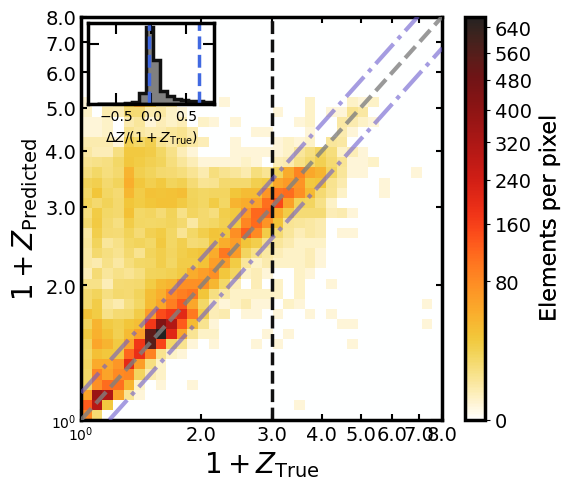

In [37]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
ax1 = gf.plot_redshift_compare(full_catalog_df.loc[:, 'Z'], full_catalog_df.loc[:, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
ax1.axvline(x=(1 + gv.high_z_limit), ls='--', c='k', lw=2.5)
if use_second_z_model:
    ax1.set_ylabel('$1 + Z_{\mathrm{Predicted}}^{\mathrm{combined\,models}}$', size=20)
plt.show()

Additional columns with radio AGN prediction as a whole.

In [38]:
full_catalog_df['pred_radio_AGN']     = np.array(full_catalog_df.loc[:, 'pred_star']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
full_catalog_df['pred_prob_rAGN']     = np.array(full_catalog_df.loc[:, 'pred_star_cal']  == 0) &\
                                        np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) &\
                                        np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)
full_catalog_df['Score_rAGN']         = full_catalog_df.loc[:, 'Score_no_star'] *\
                                        full_catalog_df.loc[:, 'Score_AGN'] *\
                                        full_catalog_df.loc[:, 'Score_radio']
full_catalog_df['Prob_rAGN']          = full_catalog_df.loc[:, 'Prob_no_star'] *\
                                        full_catalog_df.loc[:, 'Prob_AGN'] *\
                                        full_catalog_df.loc[:, 'Prob_radio']
rad_score_scaler                      = MinMaxScaler()
rad_score_scaler.fit(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_radio'] = rad_score_scaler.transform(full_catalog_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
full_catalog_df['scaled_score_rAGN']  = full_catalog_df.loc[:, 'Score_AGN'] * full_catalog_df.loc[:, 'scaled_score_radio']

In [39]:
unknown_cat_df['pred_radio_AGN']     = np.array(unknown_cat_df.loc[:, 'pred_star']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
unknown_cat_df['pred_prob_rAGN']     = np.array(unknown_cat_df.loc[:, 'pred_star_cal']  == 0) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 1) &\
                                       np.array(unknown_cat_df.loc[:, 'pred_radio_cal'] == 1)
unknown_cat_df['Score_rAGN']         = unknown_cat_df.loc[:, 'Score_no_star'] *\
                                       unknown_cat_df.loc[:, 'Score_AGN'] *\
                                       unknown_cat_df.loc[:, 'Score_radio']
unknown_cat_df['Prob_rAGN']          = unknown_cat_df.loc[:, 'Prob_no_star'] *\
                                       unknown_cat_df.loc[:, 'Prob_AGN'] *\
                                       unknown_cat_df.loc[:, 'Prob_radio']

unknown_cat_df['scaled_score_radio'] = rad_score_scaler.transform(unknown_cat_df.loc[:, 'Score_radio'].values.reshape(-1, 1))
unknown_cat_df['scaled_score_rAGN']  = unknown_cat_df.loc[:, 'Score_AGN'] * unknown_cat_df.loc[:, 'scaled_score_radio']

In [40]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'pred_class_cal', 'LOFAR_detect', 'pred_radio', 'pred_radio_cal', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
initial_stats_preds = full_catalog_df.loc[:, displayed_cols].describe().transpose()
initial_stats_preds.loc[:, 'count'] = initial_stats_preds.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(initial_stats_preds)

,count,mean,std,min,25%,50%,75%,max
class,16682,0.3387,0.4733,0.0000,0.0000,0.0000,1.0000,1.0000
pred_class,16682,0.3353,0.4721,0.0000,0.0000,0.0000,1.0000,1.0000
pred_class_cal,16682,0.3283,0.4696,0.0000,0.0000,0.0000,1.0000,1.0000
LOFAR_detect,16682,0.2841,0.4510,0.0000,0.0000,0.0000,1.0000,1.0000
pred_radio,16682,0.5541,0.4971,0.0000,0.0000,1.0000,1.0000,1.0000
pred_radio_cal,16682,0.5866,0.4925,0.0000,0.0000,1.0000,1.0000,1.0000
Z,16682,0.8196,0.7275,-0.0036,0.3383,0.5780,1.0658,6.4400
pred_Z,16682,1.2527,1.0058,0.0261,0.5188,0.8580,1.9390,4.6957


##### Obtain statistics for original redshift by class in known sources.

In [41]:
kno_summary_class                        = full_catalog_df.loc[:, 'Z'].groupby(full_catalog_df.loc[:, 'class']).describe()
kno_summary_radio_det                    = full_catalog_df.loc[:, 'Z'].groupby(full_catalog_df.loc[:, 'LOFAR_detect']).describe()
kno_summary_radio_AGN                    = full_catalog_df.loc[:, 'Z'].groupby(full_catalog_df.loc[:, 'radio_AGN']).describe()

kno_summary_ground_truth                 = pd.concat([kno_summary_class, kno_summary_radio_det, kno_summary_radio_AGN])
kno_summary_ground_truth['Class']        = ['Galaxy', 'AGN', 'No radio detected', 'Radio detected', 'No radio AGN', 'Radio AGN']

kno_summary_ground_truth                 = kno_summary_ground_truth.set_index('Class', drop=True)
kno_summary_ground_truth.loc[:, 'count'] = kno_summary_ground_truth.loc[:, 'count'].astype(int)

In [42]:
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_ground_truth)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
Galaxy,11032,0.43935,0.24833,-0.00357,0.23027,0.47222,0.60406,1.97586
AGN,5650,1.56206,0.78011,0.00300,1.00700,1.54250,2.07900,6.44000
No radio detected,11943,0.86368,0.72838,-0.00357,0.39712,0.59985,1.16900,6.44000
Radio detected,4739,0.70851,0.71325,0.00000,0.17898,0.50392,0.85260,4.24700
No radio AGN,15064,0.76427,0.68708,-0.00357,0.33025,0.55909,0.88762,6.44000
Radio AGN,1618,1.33474,0.87617,0.00300,0.55700,1.28050,1.95175,4.24700


##### Include AGN detection criteria from literature

In [43]:
full_catalog_df = add_AGN_criteria(full_catalog_df)
unknown_cat_df  = add_AGN_criteria(unknown_cat_df)

Obtain intermediate metrics

In [44]:
filter_radio_AGN_t      = np.array(full_catalog_df.loc[:, 'class'] == 1) & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
if use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1) |\
                        (full_catalog_df.loc[:, 'class'] == 2)
elif not use_zeroth_model:
    filter_known_spec = (full_catalog_df.loc[:, 'class'] == 0) |\
                        (full_catalog_df.loc[:, 'class'] == 1)
total_size              = len(full_catalog_df)
filter_gal_t            = np.array(full_catalog_df.loc[:, 'class'] == 0)
filter_AGN_t            = np.array(full_catalog_df.loc[:, 'class'] == 1)
filter_str_t            = np.array(full_catalog_df.loc[:, 'class'] == 2)
filter_radio_t          = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)
num_str_t               = np.sum(filter_str_t)
num_AGN_t               = np.sum(filter_AGN_t)
num_gal_t               = np.sum(filter_gal_t)
num_str_t               = np.sum(np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_radio_t             = np.sum(filter_radio_t)
num_radio_AGN_t         = np.sum(filter_radio_AGN_t)

In [45]:
if use_zeroth_model:
    filter_non_str_p      = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_p      = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_p        = full_catalog_df['pred_radio_AGN']
filt_hiz_rAGN_p           = filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_p              = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_non_str_p
filter_radio_p            = np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_p           = filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)
num_str_p                 = np.sum(full_catalog_df.loc[:, 'pred_star'] == 1)
num_AGN_p                 = np.sum(filter_AGN_p)
num_gal_p                 = np.sum(np.array(full_catalog_df.loc[:, 'pred_class'] == 0) & filter_non_str_p)
num_radio_p               = np.sum(filter_radio_p)
num_radio_AGN_p           = np.sum(filter_radio_AGN_p)
num_rAGN_MQC_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_p            = np.sum(filter_radio_AGN_p & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_p            = np.sum(filter_radio_AGN_p) - np.sum(filter_radio_AGN_t)

Some metrics for predicted classes based on probabilities (not scores).

In [46]:
if use_zeroth_model:
    filter_non_str_prob_p = np.array(full_catalog_df.loc[:, 'pred_star_cal'] == 0)
elif not use_zeroth_model:
    filter_non_str_prob_p = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_prob_p   = full_catalog_df['pred_prob_rAGN']
filt_hiz_rAGN_prob_p      = filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_prob_p         = np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 1) & filter_non_str_prob_p
filter_radio_prob_p       = np.array(full_catalog_df.loc[:, 'pred_radio_cal'] == 1)
filt_new_rAGN_prob_p      = filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'radio_AGN'] == 0)

num_AGN_prob_p            = np.sum(filter_AGN_prob_p)
num_gal_prob_p            = np.sum(np.array(full_catalog_df.loc[:, 'pred_class_cal'] == 0) & filter_non_str_prob_p)
num_radio_prob_p          = np.sum(filter_radio_prob_p)
num_radio_AGN_prob_p      = np.sum(filter_radio_AGN_prob_p)
num_rAGN_MQC_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 1))
num_rAGN_gal_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'class'] == 0))
num_rAGN_str_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_prob_p       = np.sum(filter_radio_AGN_prob_p & np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_prob_p       = np.sum(filter_radio_AGN_prob_p) - np.sum(filter_radio_AGN_t)

In [47]:
if use_zeroth_model:
    filter_non_str_unk_p      = np.array(unknown_cat_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_p      = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_p        = unknown_cat_df['pred_radio_AGN']
filt_hiz_rAGN_unk_p           = filter_radio_AGN_unk_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_p              = np.array(unknown_cat_df.loc[:, 'pred_class'] == 1) & filter_non_str_unk_p
filter_radio_unk_p            = np.array(unknown_cat_df.loc[:, 'pred_radio'] == 1)
filt_new_rAGN_unk_p           = filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)
num_str_unk_p                 = np.sum(unknown_cat_df.loc[:, 'pred_star'] == 1)
num_AGN_unk_p                 = np.sum(filter_AGN_unk_p)
num_gal_unk_p                 = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class'] == 0) & filter_non_str_unk_p)
num_radio_unk_p               = np.sum(filter_radio_unk_p)
num_radio_AGN_unk_p           = np.sum(filter_radio_AGN_unk_p)
num_rAGN_MQC_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_p            = np.sum(filter_radio_AGN_unk_p & np.array(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1))

In [48]:
if use_zeroth_model:
    filter_non_str_unk_prob_p = np.array(unknown_cat_df.loc[:, 'pred_star_cal'] == 0)
elif not use_zeroth_model:
    filter_non_str_unk_prob_p = np.ones_like(unknown_cat_df.loc[:, 'class']).astype(bool)
filter_radio_AGN_unk_prob_p   = unknown_cat_df['pred_prob_rAGN']
filt_hiz_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p * np.array(unknown_cat_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
filter_AGN_unk_prob_p         = np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 1) & filter_non_str_unk_prob_p
filter_radio_unk_prob_p       = np.array(unknown_cat_df.loc[:, 'pred_radio_cal'] == 1)
filt_new_rAGN_unk_prob_p      = filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'radio_AGN'] == 0)

num_AGN_unk_prob_p            = np.sum(filter_AGN_unk_prob_p)
num_gal_unk_prob_p            = np.sum(np.array(unknown_cat_df.loc[:, 'pred_class_cal'] == 0) & filter_non_str_unk_prob_p)
num_radio_unk_prob_p          = np.sum(filter_radio_unk_prob_p)
num_radio_AGN_unk_prob_p      = np.sum(filter_radio_AGN_unk_prob_p)
num_rAGN_MQC_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 1))
num_rAGN_gal_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'class'] == 0))
num_rAGN_str_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'is_str'] == 1))
num_rAGN_rad_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p & np.array(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1))
num_new_rAGN_unk_prob_p       = np.sum(filter_radio_AGN_unk_prob_p) - np.sum(filter_radio_AGN_t)

Confusion matrix for Star/not-star classification on confirmed sources (AGN + Galaxies + Stars)

In [49]:
if use_zeroth_model:
    cm_str = gf.conf_mat_func(full_catalog_df.loc[:, 'is_str'], full_catalog_df.loc[:, 'pred_star'])

Confusion matrix for AGN prediction on confirmed sources (AGN/galaxies). Including initial prediction of not being star.

In [50]:
tmp_filt_AGN = filter_non_str_p * filter_known_spec
cm_AGN = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'],\
        full_catalog_df.loc[filter_non_str_p, 'pred_class'])

cm_AGN_prob = gf.conf_mat_func(full_catalog_df.loc[filter_non_str_p, 'class'],\
        full_catalog_df.loc[filter_non_str_p, 'pred_class_cal'])

Confusion matrices from literature AGN criteria.

In [51]:
tmp_filt_sp_nostr = filter_known_spec * filter_non_str_p
cm_AGN_S12 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'S12_AGN'])

cm_AGN_M12 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'M12_AGN'])

cm_AGN_M16 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'M16_AGN'])

cm_AGN_B18 = gf.conf_mat_func(full_catalog_df.loc[tmp_filt_sp_nostr, 'class'],\
        full_catalog_df.loc[tmp_filt_sp_nostr, 'B18_AGN'])

Confusion matrix for radio detection prediction on confirmed sources (AGN/galaxies/stars)

In [52]:
cm_radio = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_p, 'LOFAR_detect'],\
        full_catalog_df.loc[filter_AGN_p, 'pred_radio'])

cm_radio_prob = gf.conf_mat_func(full_catalog_df.loc[filter_AGN_prob_p, 'LOFAR_detect'],\
        full_catalog_df.loc[filter_AGN_prob_p, 'pred_radio_cal'])

Confusion matrix for radio AGN prediction on confirmed sources (AGN/galaxies/stars)

In [53]:
cm_rAGN = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], full_catalog_df.loc[:,'pred_radio_AGN'])

cm_rAGN_prob = gf.conf_mat_func(full_catalog_df.loc[:, 'radio_AGN'], full_catalog_df.loc[:,'pred_prob_rAGN'])

Metrics from redshift predictions.

In [54]:
sigma_mad_field            = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_nmad_field           = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_field              = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
sigma_z_norm_field         = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
out_frac_field             = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])

sigma_mad_prob_field       = gf.sigma_mad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],    full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field      = gf.sigma_nmad(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],   full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_prob_field         = gf.sigma_z(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'],      full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field    = gf.sigma_z_norm(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])
out_frac_prob_field        = gf.outlier_frac(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'])

In [55]:
filt_high_z_rAGN_p         = filter_radio_AGN_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_nmad_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
sigma_z_norm_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])
out_frac_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_p, 'pred_Z'])

filt_high_z_rAGN_prob_p         = filter_radio_AGN_prob_p * (full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit)
sigma_mad_prob_field_hiz        = gf.sigma_mad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],    full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_nmad_prob_field_hiz       = gf.sigma_nmad(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],   full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_prob_field_hiz          = gf.sigma_z(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'],      full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
sigma_z_norm_prob_field_hiz     = gf.sigma_z_norm(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])
out_frac_prob_field_hiz         = gf.outlier_frac(full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'Z'], full_catalog_df.loc[filt_high_z_rAGN_prob_p, 'pred_Z'])

Plot histograms for scores.

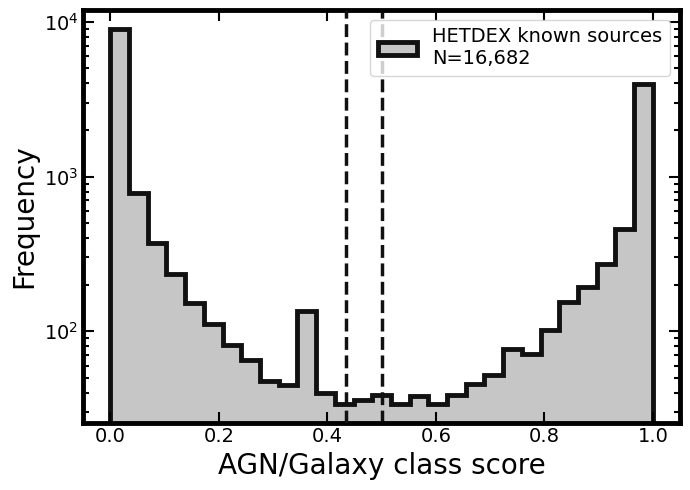

In [56]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

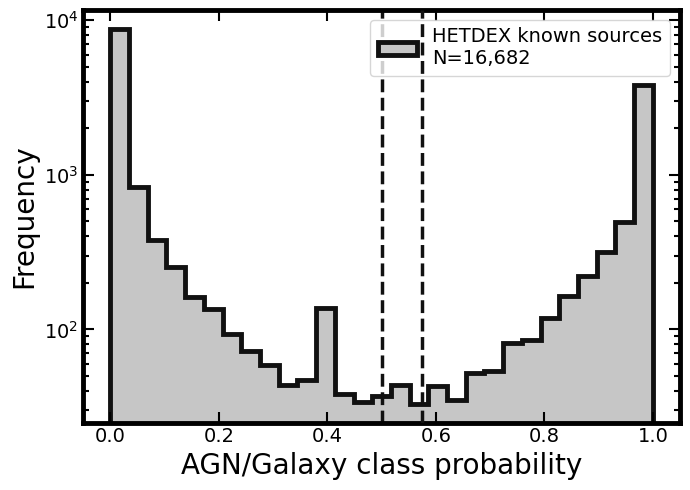

In [57]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
max_score  = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.cal_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

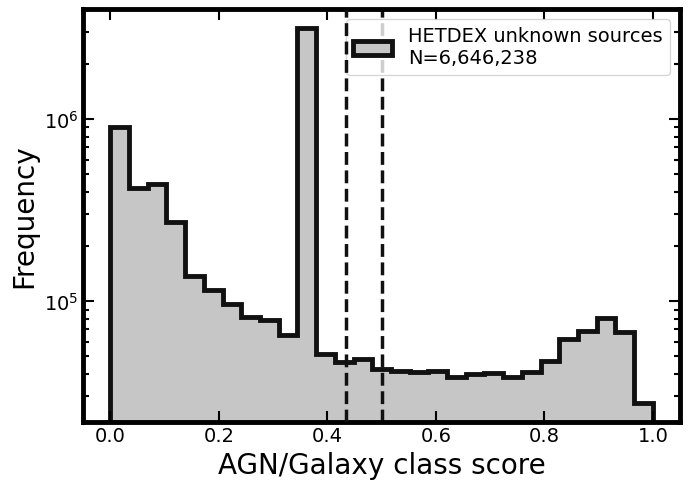

In [58]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Score_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_scores_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

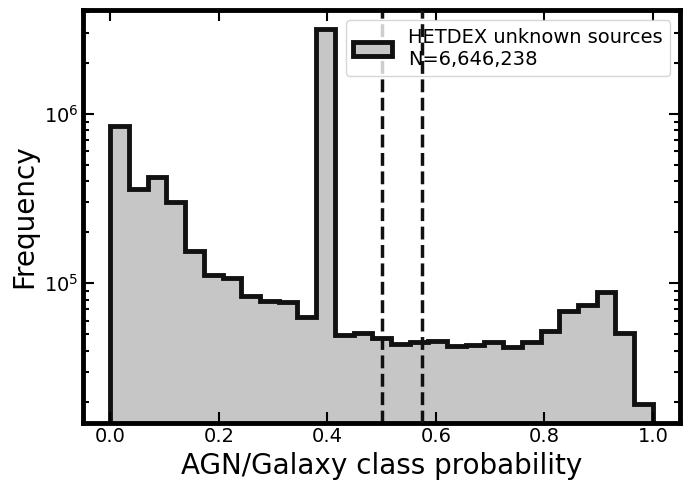

In [59]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
max_score  = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'])
score_bins = np.linspace(min_score, max_score, 30)

sample_size = np.sum(filter_non_str_unk_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_p, 'Prob_AGN'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh, ls='--', c='k', lw=2.5)
ax1.axvline(x=gv.cal_AGN_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_AGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

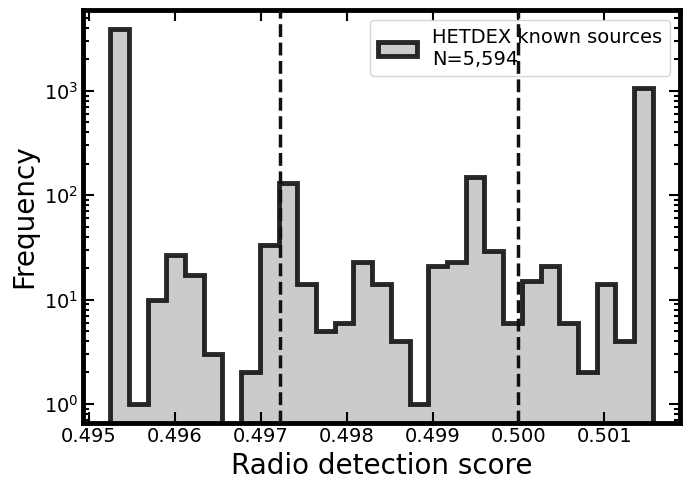

In [60]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_p)

ax1.hist(full_catalog_df.loc[filter_AGN_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

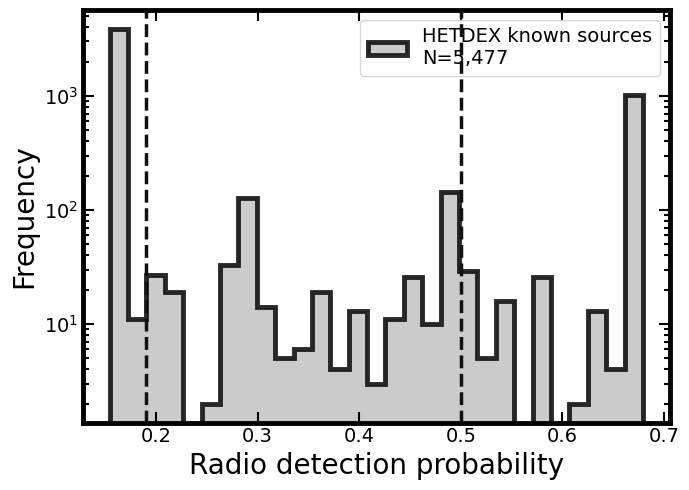

In [61]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_AGN_prob_p, 'Prob_radio'])
max_score       = np.nanmax(full_catalog_df.loc[filter_AGN_prob_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_prob_p)

ax1.hist(full_catalog_df.loc[filter_AGN_prob_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_prob_pred_AGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

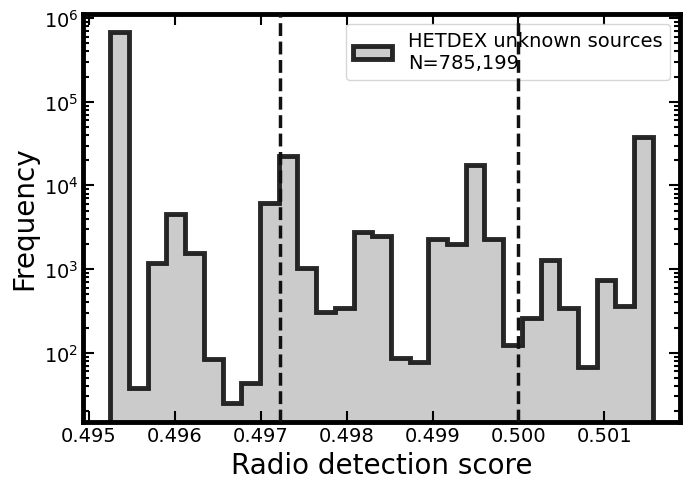

In [62]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_p, 'Score_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection score', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_scores_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

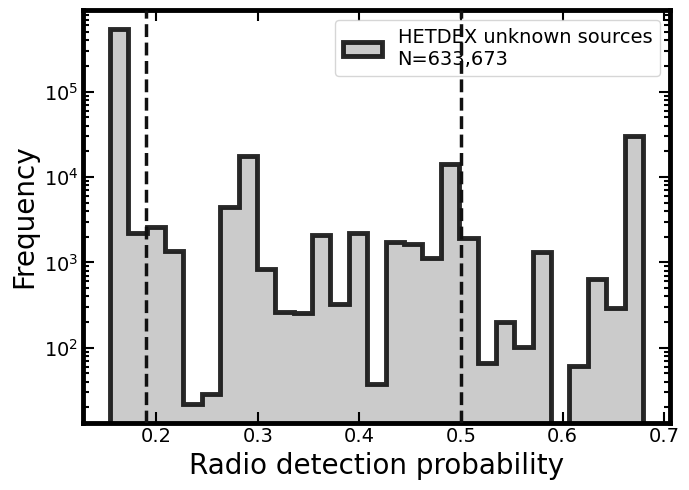

In [63]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_AGN_unk_prob_p, 'Prob_radio'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_AGN_unk_prob_p, 'Prob_radio'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_AGN_unk_prob_p)

ax1.hist(unknown_cat_df.loc[filter_AGN_unk_prob_p, 'Prob_radio'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio detection probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_radio_probs_pred_AGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

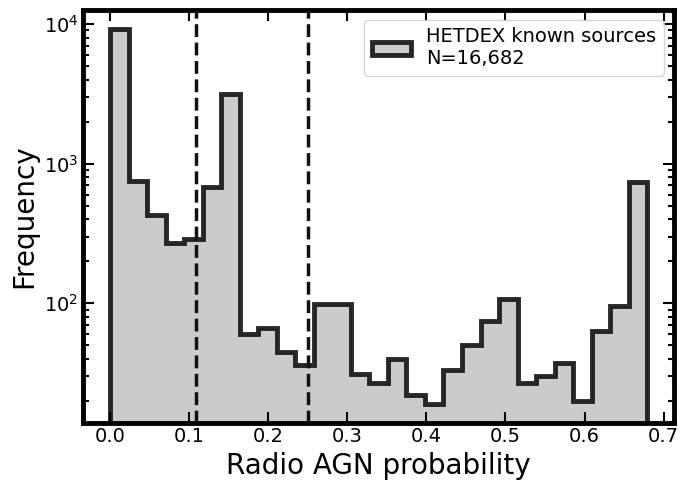

In [64]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
max_score       = np.nanmax(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_p)

ax1.hist(full_catalog_df.loc[filter_non_str_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_AGN_thresh * gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

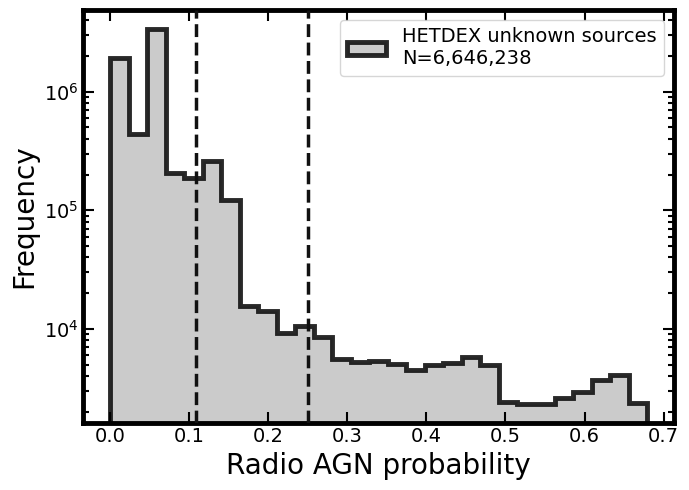

In [65]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_non_str_unk_prob_p, 'Prob_rAGN'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_non_str_unk_prob_p, 'Prob_rAGN'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_non_str_unk_prob_p)

ax1.hist(unknown_cat_df.loc[filter_non_str_unk_prob_p, 'Prob_rAGN'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.naive_AGN_thresh * gv.naive_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
ax1.axvline(x=gv.cal_AGN_thresh * gv.cal_radio_thresh, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN probability', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
fig.tight_layout()
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_rAGN_probs_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

Plot histograms for predicted and original redshifts.

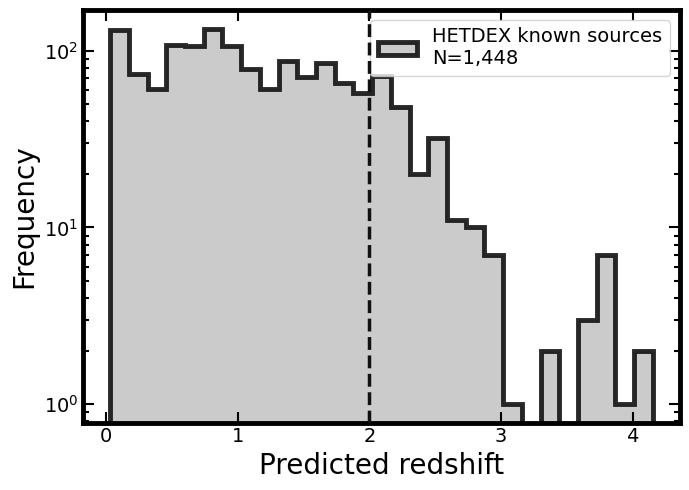

In [66]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
max_score       = np.nanmax(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_p)

ax1.hist(full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} known sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_known_{used_area}.pdf', bbox_inches='tight')
plt.show()

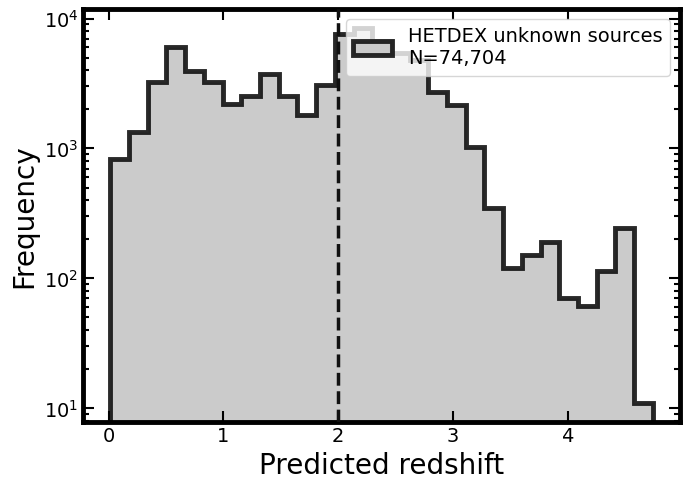

In [67]:
fig             = plt.figure(figsize=(7,5.0))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score       = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_score       = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
score_bins      = np.linspace(min_score, max_score, 30)

sample_size     = np.sum(filter_radio_AGN_unk_p)

ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=score_bins,\
         histtype='stepfilled', ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.9,\
         label=f'{used_area} unknown sources\nN={sample_size:,}')

ax1.axvline(x=gv.high_z_limit, ls='--', c='k', lw=2.5, zorder=10)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Predicted redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_redshift_rAGN_unknown_{used_area}.pdf', bbox_inches='tight')
plt.show()

In [68]:
displayed_cols = ['is_str', 'pred_star', 'class', 'pred_class', 'LOFAR_detect', 'pred_radio', 'Z', 'pred_Z']
if not use_zeroth_model:
    displayed_cols.remove('is_str')
    displayed_cols.remove('pred_star')
print('Predictions for known sources:')
display(full_catalog_df.loc[filter_radio_AGN_p, displayed_cols].describe())
print('\nPredictions for unknown sources:')
display(unknown_cat_df.loc[filter_radio_AGN_unk_p, displayed_cols].describe())

Predictions for known sources:


,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,1448.000000,1448.0,1448.000000,1448.0,1448.000000,1448.000000
mean,0.926796,1.0,0.590470,1.0,1.127091,1.167085
std,0.260562,0.0,0.491917,0.0,0.810853,0.752696
min,0.000000,1.0,0.000000,1.0,0.000000,0.032100
25%,1.000000,1.0,0.000000,1.0,0.492900,0.587750
50%,1.000000,1.0,1.000000,1.0,0.948715,1.029100
75%,1.000000,1.0,1.000000,1.0,1.653500,1.682000
max,1.000000,1.0,1.000000,1.0,4.231000,4.153100



Predictions for unknown sources:


,class,pred_class,LOFAR_detect,pred_radio,Z,pred_Z
count,74704.0,74704.0,74704.000000,74704.0,701.000000,74704.000000
mean,0.5,1.0,0.280132,1.0,0.670575,1.803116
std,0.0,0.0,0.449067,0.0,0.984706,0.860668
min,0.5,1.0,0.000000,1.0,-0.001320,0.015700
25%,0.5,1.0,0.000000,1.0,0.100000,0.996875
50%,0.5,1.0,0.000000,1.0,0.300000,2.050300
75%,0.5,1.0,1.000000,1.0,0.832930,2.425400
max,0.5,1.0,1.000000,1.0,6.879030,4.739000


Add individual metrics for redshift

In [69]:
full_catalog_df['Delta_z_N'] = np.around((full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

full_catalog_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_df.loc[:, 'pred_Z'] - full_catalog_df.loc[:, 'Z']) /\
                            (1 + full_catalog_df.loc[:, 'Z']), decimals=3)

Numerical summary.

In [70]:
str_0_t     = f'Out of {total_size:,} initially known sources in {used_area},\n'
str_1_t     = f'{num_gal_t:,} are confirmed to be galaxies. On the other side,\n'
str_2_t     = f'{num_str_t:,} are listed as SDSS-DR16 stars and {num_AGN_t:,} are MQC AGN.\n'
str_3_t     = f'Also, {num_radio_AGN_t:,} AGN are detected in radio (i.e. Radio Galaxies).'

str_0_kno_p = f'Out of {len(full_catalog_df):,} initially known sources in {used_area},\n'
str_1_kno_p = f'{num_gal_p:,} are predicted to be galaxies. On the other side,\n'
str_2_kno_p = f'{num_str_p:,} are predicted as SDSS-DR16 stars and {num_AGN_p:,} are MQC AGN.\n'
str_3_kno_p = f'Also, {num_radio_AGN_p:,} AGN are predicted to bedetected in radio.'

str_0_unk_p = f'Out of {len(unknown_cat_df):,} initially unknown sources in {used_area},\n'
str_1_unk_p = f'{num_gal_unk_p:,} are predicted to be galaxies. On the other side,\n'
str_2_unk_p = f'{num_str_unk_p:,} are predicted as SDSS-DR16 stars and {num_AGN_unk_p:,} are MQC AGN.\n'
str_3_unk_p = f'Also, {num_radio_AGN_unk_p:,} AGN are predicted to be detected in radio.'

In [71]:
print('-' * 60)
print(str_0_t + str_1_t + str_2_t + str_3_t)
print('-' * 60)

print('-' * 60)
print(str_0_kno_p + str_1_kno_p + str_2_kno_p + str_3_kno_p)
print('-' * 60)

print('-' * 60)
print(str_0_unk_p + str_1_unk_p + str_2_unk_p + str_3_unk_p)
print('-' * 60)

------------------------------------------------------------
Out of 16,682 initially known sources in HETDEX,
11,032 are confirmed to be galaxies. On the other side,
0 are listed as SDSS-DR16 stars and 5,650 are MQC AGN.
Also, 1,618 AGN are detected in radio (i.e. Radio Galaxies).
------------------------------------------------------------
------------------------------------------------------------
Out of 16,682 initially known sources in HETDEX,
11,088 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 5,594 are MQC AGN.
Also, 1,448 AGN are predicted to bedetected in radio.
------------------------------------------------------------
------------------------------------------------------------
Out of 6,646,238 initially unknown sources in HETDEX,
5,861,039 are predicted to be galaxies. On the other side,
0 are predicted as SDSS-DR16 stars and 785,199 are MQC AGN.
Also, 74,704 AGN are predicted to be detected in radio.
----------------------------

In [72]:
show_columns = ['Name', 'RA_ICRS', 'DE_ICRS', 'TYPE', 'band_num', 'class', 'pred_class', 'Score_AGN',\
                'LOFAR_detect', 'pred_radio', 'scaled_score_radio', 'scaled_score_rAGN', 'Z', 'pred_Z']

# cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
# cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'radio_detect',\
#                              'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']
cols_4_table_pred_known   = ['RA_ICRS', 'DE_ICRS', 'band_num', 'class', 'Score_AGN', 'Prob_AGN', 'LOFAR_detect',\
                             'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'Z', 'pred_Z']
cols_4_table_pred_unknown = ['RA_ICRS', 'DE_ICRS', 'band_num', 'Score_AGN', 'Prob_AGN', 'LOFAR_detect',\
                             'Score_radio', 'Prob_radio', 'Score_rAGN', 'Prob_rAGN', 'pred_Z']

In [73]:
cols_4_export_S82    = ['Total_flux_VLASS', 'Fint_VLAS82', 'Stotal_TGSS', 'FEP']
cols_4_export_HETDEX = ['Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS']
cols_4_export_COSMOS = ['Total_flux_VLASS', 'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3']

cols_4_exp_all       = {'S82': cols_4_export_S82, 'HETDEX': cols_4_export_HETDEX, 'COSMOS': cols_4_export_COSMOS}

cols_photo           = ['W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag',\
                        'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag']

cols_4_export        = show_columns + cols_4_exp_all[used_area] + cols_photo

In [74]:
filter_high_z   = full_catalog_df.loc[:, 'pred_Z']    >= gv.high_z_limit

Display properties of predicted Radio AGN in known sample.

In [75]:
disp_table_known = full_catalog_df.loc[filter_radio_AGN_prob_p, cols_4_table_pred_known].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_known)

,RA_ICRS,DE_ICRS,band_num,class,Score_AGN,Prob_AGN,LOFAR_detect,Score_radio,Prob_radio,Score_rAGN,Prob_rAGN,Z,pred_Z
2169226,211.079056,47.114426,7,1.0,0.717709,0.724124,0,0.499095,0.448118,0.358205,0.324493,2.67700,4.1531
3454090,225.784683,52.536716,8,0.0,0.685414,0.694994,0,0.501565,0.679283,0.343780,0.472098,0.44299,4.0664
1984719,183.907364,54.993698,9,1.0,0.940852,0.931245,1,0.501565,0.679283,0.471898,0.632579,4.10700,3.9506
5465177,181.284851,51.269600,5,1.0,0.856216,0.849909,0,0.499585,0.495449,0.427753,0.421087,2.09300,3.8605
4899124,212.012451,53.865086,9,1.0,0.942937,0.933366,0,0.500405,0.574486,0.471850,0.536206,4.06400,3.8260


LaTeX display of same table

In [76]:
display(disp_table_known.to_latex())

'\\begin{tabular}{lrrrrrrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &    DE\\_ICRS &  band\\_num &  class &  Score\\_AGN &  Prob\\_AGN &  LOFAR\\_detect &  Score\\_radio &  Prob\\_radio &  Score\\_rAGN &  Prob\\_rAGN &        Z &  pred\\_Z \\\\\n\\midrule\n2169226 &  211.079056 &  47.114426 &         7 &    1.0 &   0.717709 &  0.724124 &             0 &     0.499095 &    0.448118 &    0.358205 &   0.324493 &  2.67700 &  4.1531 \\\\\n3454090 &  225.784683 &  52.536716 &         8 &    0.0 &   0.685414 &  0.694994 &             0 &     0.501565 &    0.679283 &    0.343780 &   0.472098 &  0.44299 &  4.0664 \\\\\n1984719 &  183.907364 &  54.993698 &         9 &    1.0 &   0.940852 &  0.931245 &             1 &     0.501565 &    0.679283 &    0.471898 &   0.632579 &  4.10700 &  3.9506 \\\\\n5465177 &  181.284851 &  51.269600 &         5 &    1.0 &   0.856216 &  0.849909 &             0 &     0.499585 &    0.495449 &    0.427753 &   0.421087 &  2.09300 &  3.8605 \\\\\n4899124 &  212.012451 &  5

Display properties predicted Radio AGN in unknown sample.

In [77]:
disp_table_unk = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, cols_4_table_pred_unknown].sort_values(by=['pred_Z'], ascending=False).head(5)
display(disp_table_unk)

,RA_ICRS,DE_ICRS,band_num,Score_AGN,Prob_AGN,LOFAR_detect,Score_radio,Prob_radio,Score_rAGN,Prob_rAGN,pred_Z
4786343,228.154526,54.541595,8,0.991423,0.987216,0,0.497309,0.288662,0.493043,0.284972,4.7390
2217066,202.498444,47.053791,8,0.639387,0.653307,0,0.499585,0.495449,0.319428,0.323681,4.7390
5715782,191.458603,50.074917,8,0.645472,0.658834,0,0.497063,0.269453,0.320840,0.177525,4.7069
2562468,217.825455,55.862751,8,0.846820,0.841223,0,0.496068,0.200465,0.420081,0.168636,4.7069
5389236,200.398926,56.027981,8,0.700025,0.708180,0,0.499502,0.487396,0.349664,0.345164,4.6701


LaTeX display of same table

In [78]:
display(disp_table_unk.to_latex())

'\\begin{tabular}{lrrrrrrrrrrr}\n\\toprule\n{} &     RA\\_ICRS &    DE\\_ICRS &  band\\_num &  Score\\_AGN &  Prob\\_AGN &  LOFAR\\_detect &  Score\\_radio &  Prob\\_radio &  Score\\_rAGN &  Prob\\_rAGN &  pred\\_Z \\\\\n\\midrule\n4786343 &  228.154526 &  54.541595 &         8 &   0.991423 &  0.987216 &             0 &     0.497309 &    0.288662 &    0.493043 &   0.284972 &  4.7390 \\\\\n2217066 &  202.498444 &  47.053791 &         8 &   0.639387 &  0.653307 &             0 &     0.499585 &    0.495449 &    0.319428 &   0.323681 &  4.7390 \\\\\n5715782 &  191.458603 &  50.074917 &         8 &   0.645472 &  0.658834 &             0 &     0.497063 &    0.269453 &    0.320840 &   0.177525 &  4.7069 \\\\\n2562468 &  217.825455 &  55.862751 &         8 &   0.846820 &  0.841223 &             0 &     0.496068 &    0.200465 &    0.420081 &   0.168636 &  4.7069 \\\\\n5389236 &  200.398926 &  56.027981 &         8 &   0.700025 &  0.708180 &             0 &     0.499502 &    0.487396 &    0.3496

Confusion matrix for AGN/galaxy prediction on all sources

In [79]:
MCC_AGN              = gf.MCC_from_CM(cm_AGN)
ACC_AGN              = gf.ACC_from_CM(cm_AGN)
F1_AGN               = gf.F1_from_CM(cm_AGN)
Recall_AGN           = gf.Recall_from_CM(cm_AGN)

MCC_AGN_prob         = gf.MCC_from_CM(cm_AGN_prob)
ACC_AGN_prob         = gf.ACC_from_CM(cm_AGN_prob)
F1_AGN_prob          = gf.F1_from_CM(cm_AGN_prob)
Recall_AGN_prob      = gf.Recall_from_CM(cm_AGN_prob)

Confusion matrix for radio detection prediction on all predicted AGN

In [80]:
MCC_radio            = gf.MCC_from_CM(cm_radio)
ACC_radio            = gf.ACC_from_CM(cm_radio)
F1_radio             = gf.F1_from_CM(cm_radio)
Recall_radio         = gf.Recall_from_CM(cm_radio)

MCC_radio_prob       = gf.MCC_from_CM(cm_radio_prob)
ACC_radio_prob       = gf.ACC_from_CM(cm_radio_prob)
F1_radio_prob        = gf.F1_from_CM(cm_radio_prob)
Recall_radio_prob    = gf.Recall_from_CM(cm_radio_prob)

Confusion matrix for radio AGN detection prediction.

In [81]:
MCC_radio_AGN         = gf.MCC_from_CM(cm_rAGN)
ACC_radio_AGN         = gf.ACC_from_CM(cm_rAGN)
F1_radio_AGN          = gf.F1_from_CM(cm_rAGN)
Recall_radio_AGN      = gf.Recall_from_CM(cm_rAGN)

MCC_radio_AGN_prob    = gf.MCC_from_CM(cm_rAGN_prob)
ACC_radio_AGN_prob    = gf.ACC_from_CM(cm_rAGN_prob)
F1_radio_AGN_prob     = gf.F1_from_CM(cm_rAGN_prob)
Recall_radio_AGN_prob = gf.Recall_from_CM(cm_rAGN_prob)

Join metrics for classification.

In [82]:
metrics_classif      = np.array([[np.sum(filter_known_spec), F1_AGN,       MCC_AGN,       Recall_AGN,       ACC_AGN],\
                                 [np.sum(filter_AGN_p),      F1_radio,     MCC_radio,     Recall_radio,     ACC_radio],\
                                 [np.sum(filter_known_spec), F1_radio_AGN, MCC_radio_AGN, Recall_radio_AGN, ACC_radio_AGN]])
metrics_classif_df   = pd.DataFrame(data=metrics_classif, columns=['Sample', 'F1', 'MCC', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

metrics_classif_prob      = np.array([[np.sum(filter_known_spec), F1_AGN_prob,       MCC_AGN_prob,       Recall_AGN_prob,       ACC_AGN_prob],\
                                 [np.sum(filter_AGN_prob_p),      F1_radio_prob,     MCC_radio_prob,     Recall_radio_prob,     ACC_radio_prob],\
                                 [np.sum(filter_known_spec),      F1_radio_AGN_prob, MCC_radio_AGN_prob, Recall_radio_AGN_prob, ACC_radio_AGN_prob]])
metrics_classif_prob_df   = pd.DataFrame(data=metrics_classif_prob, columns=['Sample', 'F1', 'MCC', 'Recall', 'Accuracy'],\
                                    index=['AGN/Galaxy', 'Radio', 'Radio AGN'])

Confusion matrices for AGN criteria from literature

In [83]:
MCC_AGN_S12          = gf.MCC_from_CM(cm_AGN_S12)
ACC_AGN_S12          = gf.ACC_from_CM(cm_AGN_S12)
F1_AGN_S12           = gf.F1_from_CM(cm_AGN_S12)
Recall_AGN_S12       = gf.Recall_from_CM(cm_AGN_S12)

MCC_AGN_M12          = gf.MCC_from_CM(cm_AGN_M12)
ACC_AGN_M12          = gf.ACC_from_CM(cm_AGN_M12)
F1_AGN_M12           = gf.F1_from_CM(cm_AGN_M12)
Recall_AGN_M12       = gf.Recall_from_CM(cm_AGN_M12)

MCC_AGN_M16          = gf.MCC_from_CM(cm_AGN_M16)
ACC_AGN_M16          = gf.ACC_from_CM(cm_AGN_M16)
F1_AGN_M16           = gf.F1_from_CM(cm_AGN_M16)
Recall_AGN_M16       = gf.Recall_from_CM(cm_AGN_M16)

MCC_AGN_B18          = gf.MCC_from_CM(cm_AGN_B18)
ACC_AGN_B18          = gf.ACC_from_CM(cm_AGN_B18)
F1_AGN_B18           = gf.F1_from_CM(cm_AGN_B18)
Recall_AGN_B18       = gf.Recall_from_CM(cm_AGN_B18)

metrics_AGN_criteria    = np.array([[F1_AGN_S12,     F1_AGN_M12,     F1_AGN_M16,     F1_AGN_B18],\
                                    [MCC_AGN_S12,    MCC_AGN_M12,    MCC_AGN_M16,    MCC_AGN_B18],\
                                    [Recall_AGN_S12, Recall_AGN_M12, Recall_AGN_M16, Recall_AGN_B18],\
                                    [ACC_AGN_S12,    ACC_AGN_M12,    ACC_AGN_M16,    ACC_AGN_B18]]) 

metrics_AGN_criteria_df = pd.DataFrame(data=metrics_AGN_criteria.T, columns=['F1', 'MCC', 'Recall', 'Accuracy'],\
                                       index=['S12', 'M12', 'M16', 'B18'])

Join metrics for regression.

In [84]:
size_rAGN    = np.sum(filter_radio_AGN_p)
size_rAGN_hz = np.sum(filter_radio_AGN_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z    = np.array([[size_rAGN, sigma_mad_early, sigma_nmad_early, sigma_z_early, sigma_z_norm_early, out_frac_early],\
                         [size_rAGN, sigma_mad_field, sigma_nmad_field, sigma_z_field, sigma_z_norm_field, out_frac_field],\
                         [size_rAGN_hz, sigma_mad_early_hiz, sigma_nmad_early_hiz, sigma_z_early_hiz, sigma_z_norm_early_hiz, out_frac_early_hiz],\
                         [size_rAGN_hz, sigma_mad_field_hiz, sigma_nmad_field_hiz, sigma_z_field_hiz, sigma_z_norm_field_hiz, out_frac_field_hiz]])
metrics_z_df = pd.DataFrame(data=metrics_z,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

size_rAGN_prob    = np.sum(filter_radio_AGN_prob_p)
size_rAGN_prob_hz = np.sum(filter_radio_AGN_prob_p * np.array(full_catalog_df.loc[:, 'pred_Z'] >= gv.high_z_limit))
metrics_z_prob    = np.array([[size_rAGN_prob, sigma_mad_prob_early, sigma_nmad_prob_early, sigma_z_prob_early,\
                               sigma_z_norm_prob_early, out_frac_prob_early],\
                         [size_rAGN_prob, sigma_mad_prob_field, sigma_nmad_prob_field, sigma_z_prob_field,\
                          sigma_z_norm_prob_field, out_frac_prob_field],\
                         [size_rAGN_prob_hz, sigma_mad_prob_early_hiz, sigma_nmad_prob_early_hiz, sigma_z_prob_early_hiz,\
                          sigma_z_norm_prob_early_hiz, out_frac_prob_early_hiz],\
                         [size_rAGN_prob_hz, sigma_mad_prob_field_hiz, sigma_nmad_prob_field_hiz, sigma_z_prob_field_hiz,\
                          sigma_z_norm_prob_field_hiz, out_frac_prob_field_hiz]])
metrics_z_prob_df = pd.DataFrame(data=metrics_z_prob,\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'],\
                            index=['First model only', 'Two models', 'First model high z', 'Second model high z'])

Print metrics

In [85]:
print('Metrics for classification steps along the pipeline using scores to obtain classes.')
metrics_classif_df.loc[:, 'Sample'] = metrics_classif_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_df)

Metrics for classification steps along the pipeline using scores to obtain classes.


,Sample,F1,MCC,Recall,Accuracy
AGN/Galaxy,16682,0.9369,0.9048,0.9322,0.9574
Radio,5594,0.5763,0.4238,0.5629,0.7753
Radio AGN,16682,0.5082,0.4594,0.4815,0.9096


In [86]:
print('Metrics for classification steps along the pipeline using probabilities to obtain classes.')
metrics_classif_prob_df.loc[:, 'Sample'] = metrics_classif_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_classif_prob_df)

Metrics for classification steps along the pipeline using probabilities to obtain classes.


,Sample,F1,MCC,Recall,Accuracy
AGN/Galaxy,16682,0.9357,0.9038,0.9214,0.9571
Radio,5477,0.5812,0.4199,0.6039,0.7661
Radio AGN,16682,0.5186,0.4674,0.5136,0.9075


In [87]:
print('Metrics for AGN detection criteria (from literature).')
print(f'Sample size, N = {np.sum(filter_known_spec):,}')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_AGN_criteria_df)

Metrics for AGN detection criteria (from literature).
Sample size, N = 16,682


,F1,MCC,Recall,Accuracy
S12,0.8153,0.7272,0.7855,0.8795
M12,0.5298,0.5154,0.3623,0.7822
M16,0.6898,0.6360,0.5381,0.8361
B18,0.8168,0.7587,0.7124,0.8918


In [88]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by scores')
metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by scores


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,1448,0.1356,0.0683,0.4062,0.2352,0.1630
Two models,1448,0.1356,0.0683,0.4062,0.2352,0.1630
First model high z,229,0.2523,0.0762,0.6754,0.4267,0.2009
Second model high z,229,0.2523,0.0762,0.6754,0.4267,0.2009


In [89]:
print('Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities')
metrics_z_prob_df.loc[:, 'Sample'] = metrics_z_prob_df.loc[:, 'Sample'].astype(int)
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_prob_df)

Metrics for redshift predictions for sources predicted to be Radio AGN by probabilities


,Sample,σ MAD,σ NMAD,σ z,σ z N,η
First model only,1587,0.1459,0.0708,0.4414,0.2679,0.1689
Two models,1587,0.1459,0.0708,0.4414,0.2679,0.1689
First model high z,285,0.2618,0.0794,0.7535,0.5078,0.2211
Second model high z,285,0.2618,0.0794,0.7535,0.5078,0.2211


## Plot predictions

### Classifications based on scores

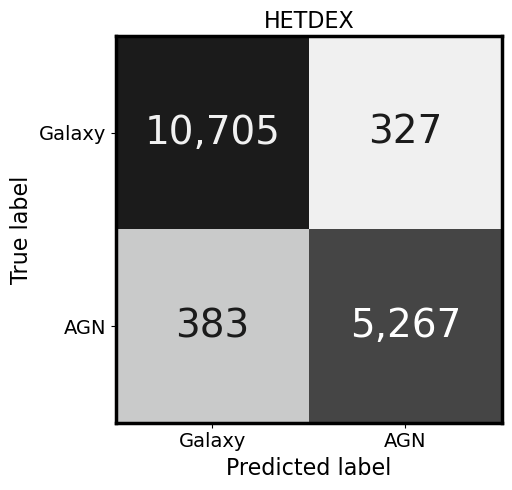

In [90]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_AGN, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

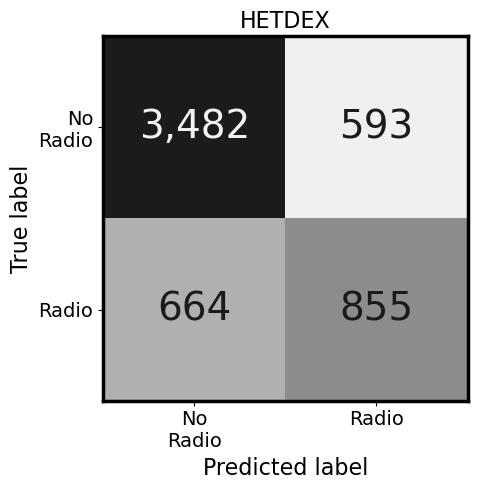

In [91]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_radio, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_{used_area}.pdf', bbox_inches='tight')
plt.show()

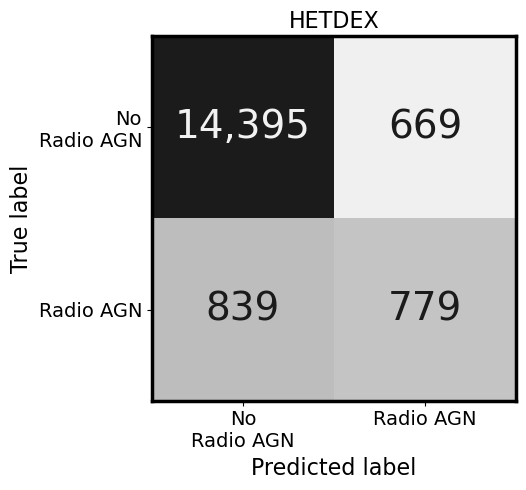

In [92]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_rAGN, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Classifications based on probabilities

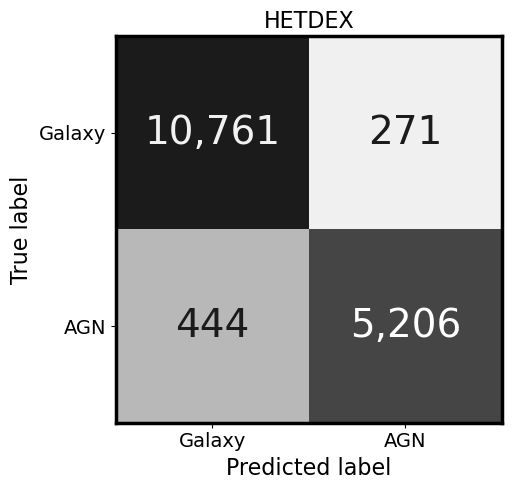

In [93]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
ax1 = gf.plot_conf_mat(cm_AGN_prob, title=used_area, axin=ax1, display_labels=['Galaxy', 'AGN'], log_stretch=False)
ax1.texts[3].set_color('white')
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

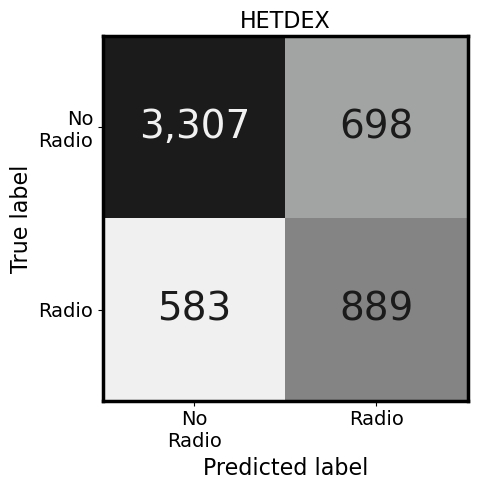

In [94]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_radio_prob, title=used_area, axin=ax1, display_labels=['No\nRadio', 'Radio'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

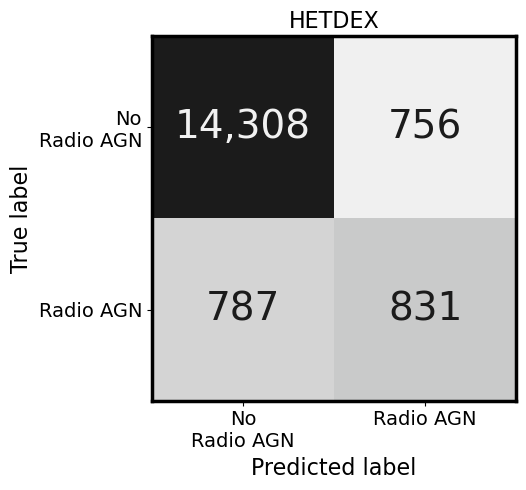

In [95]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
_ = gf.plot_conf_mat(cm_rAGN_prob, title=used_area, axin=ax1, display_labels=['No\nRadio AGN', 'Radio AGN'], log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + f'conf_matrix_radio_AGN_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by scores

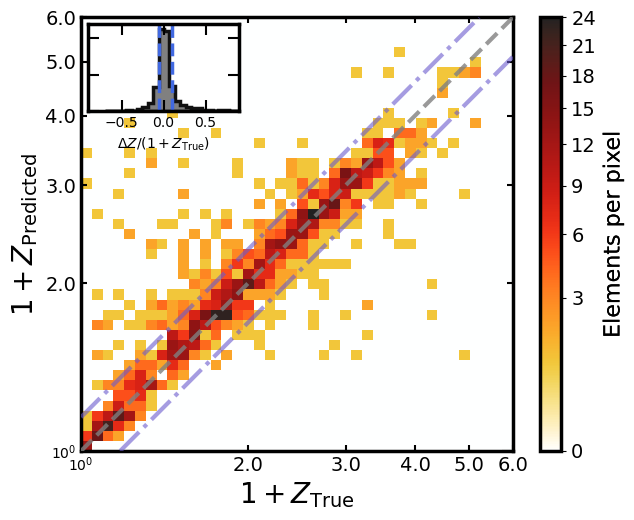

In [96]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Regression from sources by probabilities

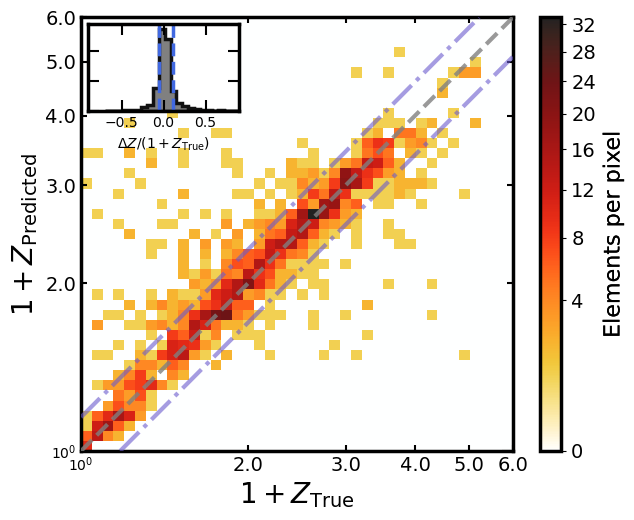

In [97]:
fig             = plt.figure(figsize=(6.8,5.3))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(full_catalog_df.loc[filter_radio_AGN_prob_p, 'Z'], full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'],\
                      ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)

if save_plot_flag:
    plt.savefig(gv.plots_path + f'compare_redshift_prob_{used_area}.pdf', bbox_inches='tight')
plt.show()

### Results from unknown sources

In [98]:
unk_summary_AGN_gal                   = unknown_cat_df.loc[:, 'Score_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class']).describe()
unk_summary_AGN_gal_probs             = unknown_cat_df.loc[:, 'Prob_AGN'].groupby(unknown_cat_df.loc[:, 'pred_class_cal']).describe()
unk_summary_radio                     = unknown_cat_df.loc[filter_AGN_unk_p,
                                                         'Score_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_p,
                                                                                                   'pred_radio']).describe()
unk_summary_radio_probs               = unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                         'Prob_radio'].groupby(unknown_cat_df.loc[filter_AGN_unk_prob_p,
                                                                                                   'pred_radio_cal']).describe()
unk_summary_z                         = unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'].describe()
unk_summary_z_probs                   = unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'].describe()
unk_summary_AGN_radio                 = pd.concat([unk_summary_AGN_gal, unk_summary_AGN_gal_probs, unk_summary_radio, unk_summary_radio_probs])
unk_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
unk_summary_AGN_radio                 = unk_summary_AGN_radio.set_index('Prediction', drop=True)
unk_summary_AGN_radio.loc['Z']        = unk_summary_z
unk_summary_AGN_radio.loc['Z (prob)'] = unk_summary_z_probs

In [99]:
unk_summary_AGN_radio.loc[:, 'count'] = unk_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(unk_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,5861039,0.24435,0.15034,0.00002,0.07797,0.36791,0.36791,0.43475
AGN,785199,0.73731,0.16523,0.43475,0.59024,0.76163,0.88663,0.99990
Galaxy (prob),6012565,0.27162,0.16371,0.00002,0.09231,0.39691,0.39691,0.57416
AGN (prob),633673,0.79667,0.11530,0.57417,0.69819,0.81785,0.89666,0.99973
No radio,710495,0.49533,0.00038,0.49525,0.49525,0.49525,0.49525,0.49723
Radio,74704,0.50040,0.00132,0.49728,0.49958,0.50140,0.50156,0.50156
No radio (prob),546851,0.15434,0.00147,0.15423,0.15423,0.15423,0.15423,0.18513
Radio (prob),86822,0.47902,0.17306,0.18992,0.28230,0.49545,0.67928,0.67928
Z,74704,1.80312,0.86067,0.01570,0.99687,2.05030,2.42540,4.73900


In [100]:
print(f"In the unknown sources, there are {np.sum(unknown_cat_df.loc[:, 'LOFAR_detect'] == 1):,} radio detected sources.")

In the unknown sources, there are 315,186 radio detected sources.


#### Same idea for known sample.

In [101]:
kno_summary_AGN_gal                   = full_catalog_df.loc[:, 'Score_AGN'].groupby(full_catalog_df.loc[:, 'pred_class']).describe()
kno_summary_AGN_gal_probs             = full_catalog_df.loc[:, 'Prob_AGN'].groupby(full_catalog_df.loc[:, 'pred_class_cal']).describe()
kno_summary_radio                     = full_catalog_df.loc[filter_AGN_p,
                                                         'Score_radio'].groupby(full_catalog_df.loc[filter_AGN_p,
                                                                                                   'pred_radio']).describe()
kno_summary_radio_probs               = full_catalog_df.loc[filter_AGN_prob_p,
                                                         'Prob_radio'].groupby(full_catalog_df.loc[filter_AGN_prob_p,
                                                                                                   'pred_radio_cal']).describe()
kno_summary_z                         = full_catalog_df.loc[filter_radio_AGN_p, 'pred_Z'].describe()
kno_summary_z_probs                   = full_catalog_df.loc[filter_radio_AGN_prob_p, 'pred_Z'].describe()
kno_summary_AGN_radio                 = pd.concat([kno_summary_AGN_gal, kno_summary_AGN_gal_probs, kno_summary_radio, kno_summary_radio_probs])
kno_summary_AGN_radio['Prediction']   = ['Galaxy', 'AGN', 'Galaxy (prob)', 'AGN (prob)', 'No radio', 'Radio', 'No radio (prob)', 'Radio (prob)']
kno_summary_AGN_radio                 = kno_summary_AGN_radio.set_index('Prediction', drop=True)
kno_summary_AGN_radio.loc['Z']        = kno_summary_z
kno_summary_AGN_radio.loc['Z (prob)'] = kno_summary_z_probs

In [102]:
kno_summary_AGN_radio.loc[:, 'count'] = kno_summary_AGN_radio.loc[:, 'count'].astype(int)
with pd.option_context('display.float_format', '{:.5f}'.format):
    display(kno_summary_AGN_radio)

,count,mean,std,min,25%,50%,75%,max
Prediction,,,,,,,,
Galaxy,11088,0.03201,0.06835,0.00002,0.00281,0.00752,0.02268,0.43369
AGN,5594,0.94528,0.10557,0.43827,0.94927,0.99282,0.99807,0.99998
Galaxy (prob),11205,0.04078,0.08929,0.00002,0.00315,0.00857,0.02709,0.56967
AGN (prob),5477,0.95167,0.08136,0.57671,0.94666,0.98970,0.99666,0.99994
No radio,4146,0.49533,0.00037,0.49525,0.49525,0.49525,0.49525,0.49723
Radio,1448,0.50098,0.00108,0.49728,0.50099,0.50156,0.50156,0.50156
No radio (prob),3890,0.15443,0.00179,0.15423,0.15423,0.15423,0.15423,0.18513
Radio (prob),1587,0.58022,0.15183,0.19042,0.49545,0.67928,0.67928,0.67928
Z,1448,1.16709,0.75270,0.03210,0.58775,1.02910,1.68200,4.15310


In [103]:
print(f"In the known sources, there are {np.sum(full_catalog_df.loc[:, 'LOFAR_detect'] == 1):,} LOFAR radio detected sources.")

In the known sources, there are 4,739 LOFAR radio detected sources.


In [104]:
print(f"In the known sources, there are {np.sum((full_catalog_df.loc[:, 'LOFAR_detect'] == 1) & (full_catalog_df.loc[:, 'class'] == 1)):,} LOFAR radio detected AGN.")

In the known sources, there are 1,618 LOFAR radio detected AGN.


#### Some properties from predicted Radio AGN

In [105]:
n_pred_rAGN_AGN_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_AGN_t])
n_pred_rAGN_gal_sco      = len(full_catalog_df.loc[filter_radio_AGN_p * filter_gal_t])
n_pred_rAGN_radio_sco    = len(full_catalog_df.loc[filter_radio_AGN_p * filter_radio_t])
n_pred_rAGN_nonradio_sco = len(full_catalog_df.loc[filter_radio_AGN_p * ~filter_radio_t])

In [106]:
str_rAGN_stats_class_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_sco:,} are galaxies and {n_pred_rAGN_AGN_sco:,} are AGN.'
str_rAGN_stats_radio_sco = f'From {num_radio_AGN_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_sco:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_sco:,} are not.'

In [107]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with scores in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_sco)
print(str_rAGN_stats_radio_sco)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with scores in the known sources of HETDEX-Validation

From 1,448 sources predicted as rAGN, 106 are galaxies and 1,342 are AGN.
From 1,448 sources predicted as rAGN, 855 are radio detected and 593 are not.
--------------------------------------------------------------------------------


In [108]:
n_pred_rAGN_AGN_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_AGN_t])
n_pred_rAGN_gal_pro      = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_gal_t])
n_pred_rAGN_radio_pro    = len(full_catalog_df.loc[filter_radio_AGN_prob_p * filter_radio_t])
n_pred_rAGN_nonradio_pro = len(full_catalog_df.loc[filter_radio_AGN_prob_p * ~filter_radio_t])

In [109]:
str_rAGN_stats_class_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN,' +\
                           f' {n_pred_rAGN_gal_pro:,} are galaxies and {n_pred_rAGN_AGN_pro:,} are AGN.'
str_rAGN_stats_radio_pro = f'From {num_radio_AGN_prob_p:,} sources predicted as rAGN, {n_pred_rAGN_radio_pro:,}' +\
                           f' are radio detected and {n_pred_rAGN_nonradio_pro:,} are not.'

In [110]:
print('-' * 80)
print('Statistics from sources predicted to be Radio AGN')
print(f'with probabilities in the known sources of {used_area}-{HETDEX_subset}')
print()
print(str_rAGN_stats_class_pro)
print(str_rAGN_stats_radio_pro)
print('-' * 80)

--------------------------------------------------------------------------------
Statistics from sources predicted to be Radio AGN
with probabilities in the known sources of HETDEX-Validation

From 1,587 sources predicted as rAGN, 89 are galaxies and 1,498 are AGN.
From 1,587 sources predicted as rAGN, 889 are radio detected and 698 are not.
--------------------------------------------------------------------------------


#### Histograms for predicted sources in unknown sources.

Predictions from scores.

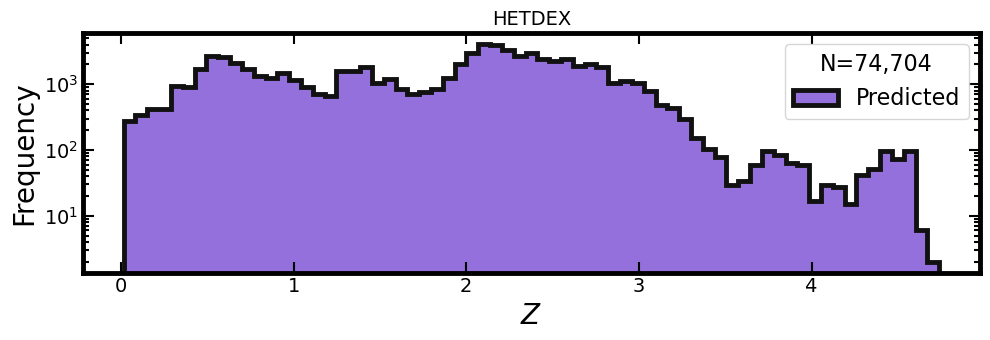

In [111]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_{used_area}_unknown.pdf')
plt.show()

Predictions from probabilities.

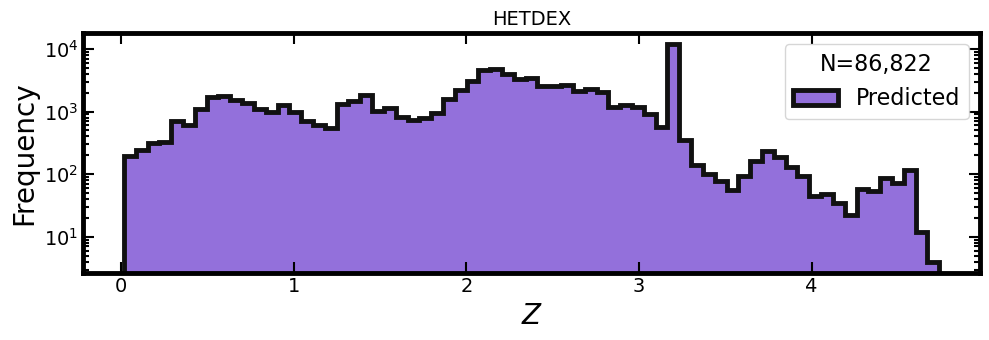

In [112]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
max_for_range = np.nanmax(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'])
bins_z        = np.linspace(min_for_range, max_for_range, 70)

_, bins, _ = ax1.hist(unknown_cat_df.loc[filter_radio_AGN_unk_prob_p, 'pred_Z'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f'Predicted')

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=16, title=f'N={np.sum(filter_radio_AGN_unk_prob_p):,}', title_fontsize=16)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + f'hist_predicted_z_prob_{used_area}_unknown.pdf')
plt.show()

### Assess probabilities and compare with scores

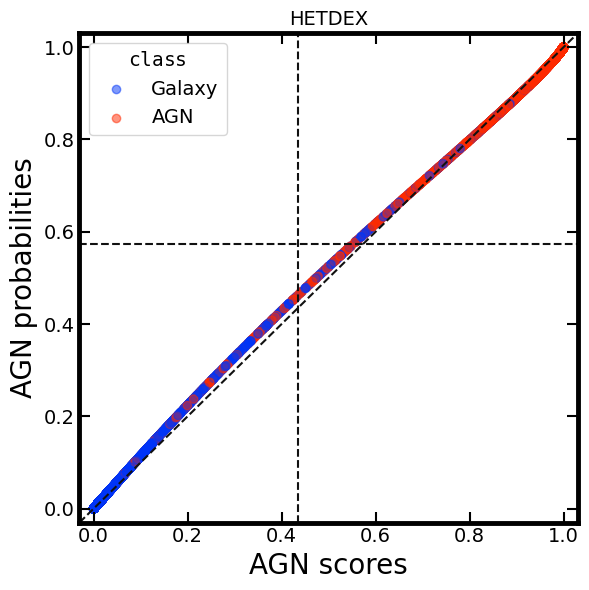

In [113]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_AGN'], full_catalog_df.loc[:, 'Prob_AGN'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'class'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class']))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=gv.cal_AGN_thresh, color='k', ls='dashed')
ax1.axvline(x=gv.AGN_thresh, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Galaxy',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'class'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores', size=20)
ax1.set_ylabel('AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

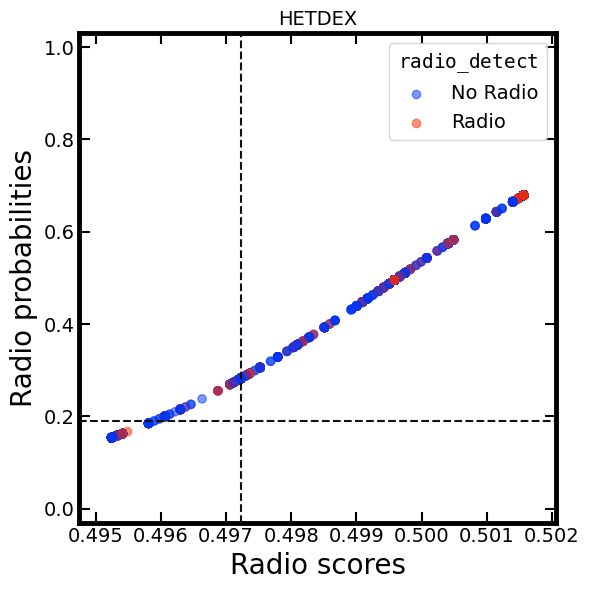

In [114]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_radio'], full_catalog_df.loc[:, 'Prob_radio'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'LOFAR_detect'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'LOFAR_detect']))))
# ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=gv.cal_radio_thresh, color='k', ls='dashed')
ax1.axvline(x=gv.radio_thresh, color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'LOFAR_detect'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'LOFAR_detect'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio scores', size=20)
ax1.set_ylabel('Radio probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_xlim(left=full_catalog_df.loc[:, 'Score_radio'].min() * 0.999, right=full_catalog_df.loc[:, 'Score_radio'].max() * 1.001)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

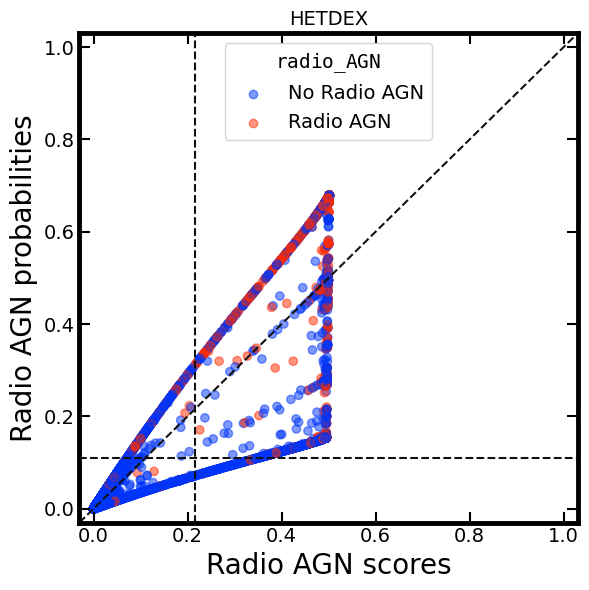

In [115]:
fig             = plt.figure(figsize=(6,6))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

ax1.scatter(full_catalog_df.loc[:, 'Score_rAGN'], full_catalog_df.loc[:, 'Prob_rAGN'], marker='o',\
            alpha=0.5, c=full_catalog_df.loc[:, 'radio_AGN'],\
            cmap=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'radio_AGN']))))
ax1.axline([0,0], [1,1], color='k', ls='dashed')
ax1.axhline(y=(gv.cal_AGN_thresh * gv.cal_radio_thresh), color='k', ls='dashed')
ax1.axvline(x=(gv.AGN_thresh * gv.radio_thresh), color='k', ls='dashed')

ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='No Radio AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'radio_AGN'])))(0.0))
ax1.scatter([-1.], [-1.], marker='o', alpha=0.5, label='Radio AGN',\
            color=plt.get_cmap('cet_rainbow',len(np.unique(full_catalog_df.loc[:, 'radio_AGN'])))(1.0))

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN scores', size=20)
ax1.set_ylabel('Radio AGN probabilities', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_AGN}$', title_fontsize=14)
ax1.set_xlim(left=-0.03, right=1.03)
ax1.set_ylim(bottom=-0.03, top=1.03)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

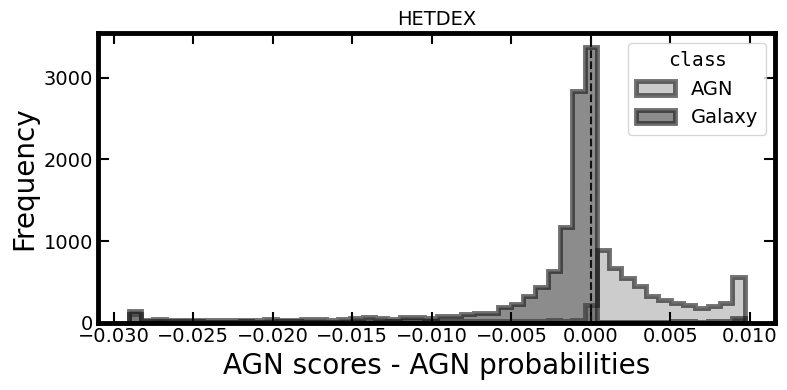

In [116]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')

filt_tmp_AGN    = np.array(full_catalog_df.loc[:, 'class'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_AGN, 'Score_AGN'] - full_catalog_df.loc[filt_tmp_AGN, 'Prob_AGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.3), ec='k', bins=50, lw=3.5, alpha=0.6, label='AGN')
plt.hist((full_catalog_df.loc[~filt_tmp_AGN, 'Score_AGN'] - full_catalog_df.loc[~filt_tmp_AGN, 'Prob_AGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.8), ec='k', bins=50, lw=3.5, alpha=0.6, label='Galaxy')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN scores - AGN probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{class}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

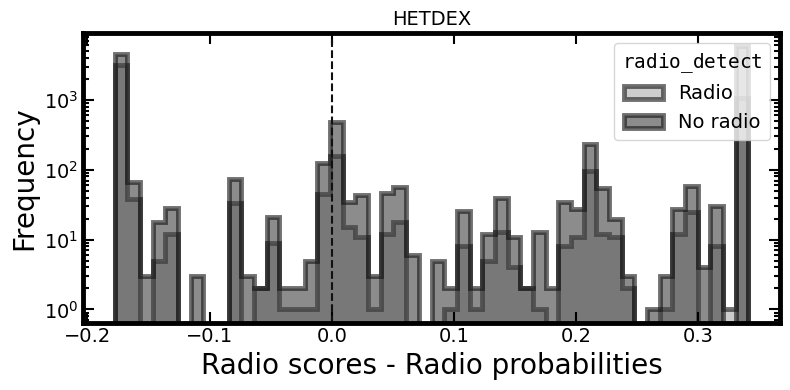

In [117]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_tmp_radio  = np.array(full_catalog_df.loc[:, 'LOFAR_detect'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_radio, 'Score_radio'] - full_catalog_df.loc[filt_tmp_radio, 'Prob_radio']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.3), ec='k', bins=50, lw=3.5, alpha=0.6, label='Radio')
plt.hist((full_catalog_df.loc[~filt_tmp_radio, 'Score_radio'] - full_catalog_df.loc[~filt_tmp_radio, 'Prob_radio']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.8), ec='k', bins=50, lw=3.5, alpha=0.6, label='No radio')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio scores - Radio probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_detect}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

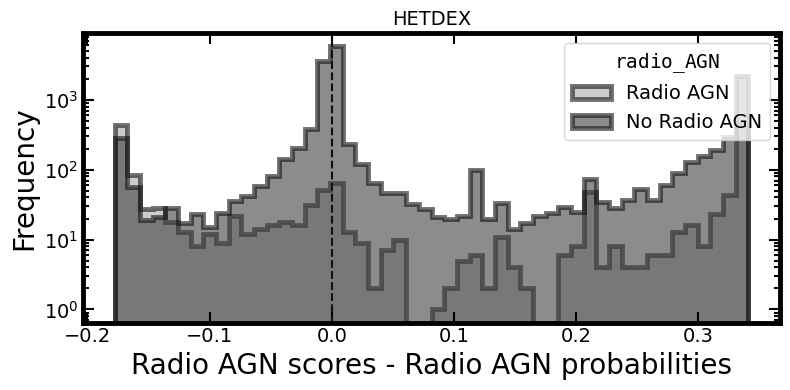

In [118]:
fig             = plt.figure(figsize=(8,4))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

filt_tmp_rAGN    = np.array(full_catalog_df.loc[:, 'radio_AGN'] == 1)

plt.hist((full_catalog_df.loc[filt_tmp_rAGN, 'Score_rAGN'] - full_catalog_df.loc[filt_tmp_rAGN, 'Prob_rAGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.3), ec='k', bins=50, lw=3.5, alpha=0.6, label='Radio AGN')
plt.hist((full_catalog_df.loc[~filt_tmp_rAGN, 'Score_rAGN'] - full_catalog_df.loc[~filt_tmp_rAGN, 'Prob_rAGN']),\
         histtype='stepfilled', fc=plt.get_cmap(gv.cmap_conf_matr)(0.8), ec='k', bins=50, lw=3.5, alpha=0.6, label='No Radio AGN')
plt.axvline(x=0.0, color='k', ls='dashed')
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Radio AGN scores - Radio AGN probabilities', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
ax1.legend(loc='best', fontsize=14, title='$\mathtt{radio\_AGN}$', title_fontsize=14)
ax1.set_title(used_area, fontsize=14)
fig.tight_layout()
plt.show()

---

## Additional test with data from Ananna et al., 2017

In [119]:
if compare_A17_flag:
    full_catalog_A17_df = pd.read_hdf(gv.cat_path + gv.file_S82_Ananna_17, key='df').drop(columns=features_2_discard)

In [120]:
if compare_A17_flag:
    full_catalog_A17_df = pyr.predict_model(redshift_reg, data=full_catalog_A17_df, round=8)
    full_catalog_A17_df = full_catalog_A17_df.rename(columns={'Label': 'pred_Z', 'is_AGN': 'class'})
    full_catalog_A17_df['pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)
    redshift_tol    = 0.0
    if use_second_z_model:
        full_catalog_A17_df = pyr.predict_model(redshift_reg_2, data=full_catalog_A17_df, round=8)
        filter_pred_z_A17   = full_catalog_A17_df.loc[:, 'pred_Z'] >= (gv.high_z_limit + redshift_tol)
        full_catalog_A17_df.loc[:, 'pred_Z'] = full_catalog_A17_df.loc[:, 'pred_Z'].mask(filter_pred_z_A17, full_catalog_A17_df.loc[filter_pred_z_A17, 'Label'])
        full_catalog_A17_df = full_catalog_A17_df.drop(columns=['Label'])
        full_catalog_A17_df.loc[:, 'pred_Z'] = np.around(full_catalog_A17_df.loc[:, 'pred_Z'], decimals=6)

In [121]:
if compare_A17_flag:
    sigma_mad_AGN_A17            = gf.sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_AGN_A17           = gf.sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_AGN_A17              = gf.sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_AGN_A17         = gf.sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_AGN_A17             = gf.outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [122]:
if compare_A17_flag:
    size_AGN_A17         = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']) & np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    metrics_z_AGN_A17    = np.array([size_AGN_A17, sigma_mad_AGN_A17, sigma_nmad_AGN_A17, sigma_z_AGN_A17,
                                     sigma_z_norm_AGN_A17, out_frac_AGN_A17])
    metrics_z_A17_df = pd.DataFrame(columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])
    metrics_z_A17_df.loc['AGN'] = metrics_z_AGN_A17

In [123]:
if compare_A17_flag:
    fig              = plt.figure(figsize=(7.5,4.3))
    ax1              = fig.add_subplot(111, xscale='linear', yscale='linear')
    
    min_score        = np.nanmin([np.nanmin(full_catalog_A17_df.loc[:, 'zsp']), np.nanmin(full_catalog_A17_df.loc[:, 'pred_Z'])])
    max_score        = np.nanmax([np.nanmax(full_catalog_A17_df.loc[:, 'zsp']), np.nanmax(full_catalog_A17_df.loc[:, 'pred_Z'])])
    score_bins       = np.linspace(min_score, max_score, 30)
    
    sample_size_orig = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']))
    sample_size_pred = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    
    ax1.hist(full_catalog_A17_df.loc[:, 'zsp'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.8,\
             label=f'Original\nN={sample_size_orig:,}', zorder=2)
    ax1.hist(full_catalog_A17_df.loc[:, 'pred_Z'], bins=score_bins, histtype='stepfilled',\
             ec='k', lw=3.5, color=cm.get_cmap('cet_gray')(0.9), alpha=0.9,\
             label=f'Predicted\nN={sample_size_pred:,}', zorder=1)
        
    ax1.tick_params(which='both', top=True, right=True, direction='in')
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(which='major', length=8, width=1.5)
    ax1.tick_params(which='minor', length=4, width=1.5)
    ax1.set_xlabel('Redshift', size=20)
    ax1.set_ylabel('Frequency', size=20)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.setp(ax1.spines.values(), linewidth=3.5)
    plt.legend(loc=1, fontsize=14)
    plt.grid(False)
    ax1.set_title('S82: Ananna+17')
    #ax1.set_aspect('equal', 'box')
    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'hist_redshift_AGN_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()

In [124]:
if compare_A17_flag:
    full_catalog_A17_df = full_catalog_A17_df.loc[np.array(full_catalog_A17_df.loc[:, 'class'] == 1) &\
                                                  np.array(full_catalog_A17_df.loc[:, 'VLAS82_detect'] == 1)]

In [125]:
if compare_A17_flag:
    used_z_col = 'zsp'
    full_catalog_A17_df['Delta_z_N'] = np.around((full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                 (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)
    full_catalog_A17_df['sigma_NMAD'] = np.around(1.48 * np.abs(full_catalog_A17_df.loc[:, 'pred_Z'] - full_catalog_A17_df.loc[:, used_z_col]) /\
                                                  (1 + full_catalog_A17_df.loc[:, used_z_col]), decimals=3)

In [126]:
if compare_A17_flag:
    show_columns_A17 = ['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'band_num', 'Z', 'zsp', 'pred_Z', 'Delta_z_N']
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by='pred_Z', ascending=False).head(10))
        display(full_catalog_A17_df.loc[:, show_columns_A17].sort_values(by=used_z_col, ascending=False).head(10))

In [127]:
if compare_A17_flag:
    sigma_mad_rAGN_A17            = gf.sigma_mad(full_catalog_A17_df.loc[:, 'Z'],    full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_nmad_rAGN_A17           = gf.sigma_nmad(full_catalog_A17_df.loc[:, 'Z'],   full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_rAGN_A17              = gf.sigma_z(full_catalog_A17_df.loc[:, 'Z'],      full_catalog_A17_df.loc[:, 'pred_Z'])
    sigma_z_norm_rAGN_A17         = gf.sigma_z_norm(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])
    out_frac_rAGN_A17             = gf.outlier_frac(full_catalog_A17_df.loc[:, 'Z'], full_catalog_A17_df.loc[:, 'pred_Z'])

In [128]:
if compare_A17_flag:
    size_rAGN_A17     = np.sum(np.isfinite(full_catalog_A17_df.loc[:, 'zsp']) & np.isfinite(full_catalog_A17_df.loc[:, 'pred_Z']))
    metrics_z_rAGN_A17    = np.array([size_rAGN_A17, sigma_mad_rAGN_A17, sigma_nmad_rAGN_A17, sigma_z_rAGN_A17,
                                 sigma_z_norm_rAGN_A17, out_frac_rAGN_A17])
    metrics_z_A17_df.loc['Radio AGN'] = metrics_z_rAGN_A17

In [129]:
if compare_A17_flag:
    print('Metrics for redshift predictions in all AGN and Radio AGN from Ananna et al., 2017 with counterparts in our sample')
    metrics_z_A17_df.loc[:, 'Sample'] = metrics_z_A17_df.loc[:, 'Sample'].astype(int)
    with pd.option_context('display.float_format', '{:.4f}'.format):
        display(metrics_z_A17_df)

In [130]:
if compare_A17_flag:
    fig             = plt.figure(figsize=(6,5))
    ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
    _ = gf.plot_redshift_compare(full_catalog_A17_df.loc[:, used_z_col], full_catalog_A17_df.loc[:, 'pred_Z'],\
                          ax_pre=ax1, title=None, dpi=10, show_clb=True, log_stretch=False)
    if save_plot_flag:
        plt.savefig(gv.plots_path + f'compare_redshift_{used_area}_Ananna_17.pdf', bbox_inches='tight')
    plt.show()